In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from scipy import stats
import statsmodels.api as sm
import itertools
import re

## Steam User Dataset

#### Step 1: Read in the data and take a look at the dataset

In [3]:
df1 = pd.read_csv('data/Steam_users.csv', 
                  header=None, names=['id', 'game', 'behavior', 'hrs', 'tmp'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        200000 non-null  int64  
 1   game      200000 non-null  object 
 2   behavior  200000 non-null  object 
 3   hrs       200000 non-null  float64
 4   tmp       200000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [6]:
df1.head()

,id,game,behavior,hrs,tmp
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [22]:
print(df1.groupby('id').count().shape)
print(df1.groupby('game').count().shape)

(12393, 4)
(5155, 4)


The user dataset contains a total of 200,000 rows, including 5,155 unique games and 12,393 unique users. 

#### Step 2: Drop the unrelated column to the project

In [23]:
df1['tmp'].value_counts()

0    200000
Name: tmp, dtype: int64

In [24]:
# the 'tmp' column only has value "0", and won't be used in the project
user = df1.drop('tmp', axis=1)

#### Step 3 Reshape the dataset

In [27]:
# Create a new column 'purchase' to represent user's ownership of the game
user['purchase'] = (user['behavior'] == 'purchase').astype(int)

0         1
1         0
2         1
3         0
4         1
         ..
199995    0
199996    1
199997    0
199998    1
199999    0
Name: purchase, Length: 200000, dtype: int64

In [30]:
# Create a new column 'play' to represent if user have played the game
user['play'] = (user['behavior'] == 'play').astype(int)

In [31]:
# Remove the purchase value to make 'hrs' column represent play hours of each game
user['hrs'] = user['hrs'] - user['purchase']

In [59]:
# Remove the 0 value in 'hrs'
user_clean = user.groupby(by=['id', 'game']).agg({'hrs': 'sum', 'purchase': 'sum', 'play': 'sum'}).reset_index()
user_clean

,id,game,hrs,purchase,play
0,5250,Alien Swarm,4.9,1,1
1,5250,Cities Skylines,144.0,1,1
2,5250,Counter-Strike,0.0,1,0
3,5250,Counter-Strike Source,0.0,1,0
4,5250,Day of Defeat,0.0,1,0
...,...,...,...,...,...
128799,309626088,Age of Empires II HD Edition,6.7,1,1
128800,309812026,Counter-Strike Nexon Zombies,0.0,1,0
128801,309812026,Robocraft,0.0,1,0
128802,309824202,Dota 2,0.7,1,1


#### Step 4: Exploratory Data Analysis

In [35]:
# Reformat the dataframe
user_data = user_clean.groupby(by='game').agg({'id': 'count', 'hrs': 'sum'})

,id,hrs
game,,
007 Legends,1,0.7
0RBITALIS,3,1.2
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),7,20.0
10 Second Ninja,6,5.9
"10,000,000",1,3.6
...,...,...
sZone-Online,102,56.7
samurai_jazz,1,0.0
the static speaks my name,13,2.0


In [39]:
# Calculate the total number of users of each game
total_users_game = user_data.sort_values(by='id',ascending=False).reset_index()
total_users_game

,game,id,hrs
0,Dota 2,4841,981684.6
1,Team Fortress 2,2323,173673.3
2,Unturned,1563,16096.4
3,Counter-Strike Global Offensive,1412,322771.6
4,Half-Life 2 Lost Coast,981,184.4
...,...,...,...
5150,EverQuest Seeds of Destruction,1,0.3
5151,Everlasting Summer DLC One pioneer's story,1,0.0
5152,Everyday Genius SquareLogic,1,12.2
5153,EvilQuest,1,0.0


In [41]:
# Calculate the total hours been played of each game
total_hours_game = user_data.sort_values(by='hrs',ascending=False).reset_index()
total_hours_game

,game,id,hrs
0,Dota 2,4841,981684.6
1,Counter-Strike Global Offensive,1412,322771.6
2,Team Fortress 2,2323,173673.3
3,Counter-Strike,856,134261.1
4,Sid Meier's Civilization V,596,99821.3
...,...,...,...
5150,Omerta - The Con Artist,6,0.0
5151,Omerta - Damsel in Distress,6,0.0
5152,Omerta - City of Gangsters The Bulgarian Colossus,8,0.0
5153,Beat Hazard - Shadow Operations Unit,6,0.0


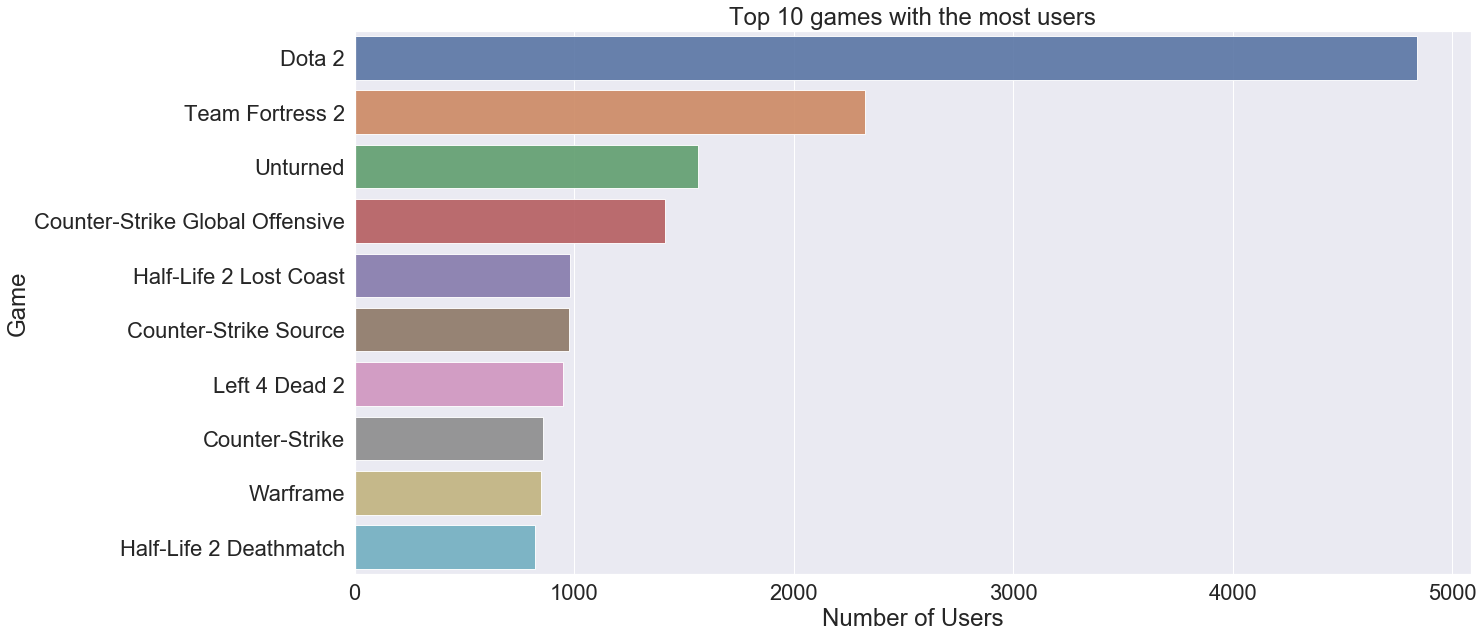

In [40]:
# Plot the top 10 games with the most user
plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)
ax = sns.barplot(x='id', y='game', alpha=0.9, data=total_users_game[:10], dodge=False)
ax.set(xlabel='Number of Users', ylabel='Game', title='Top 10 games with the most users')
plt.show()

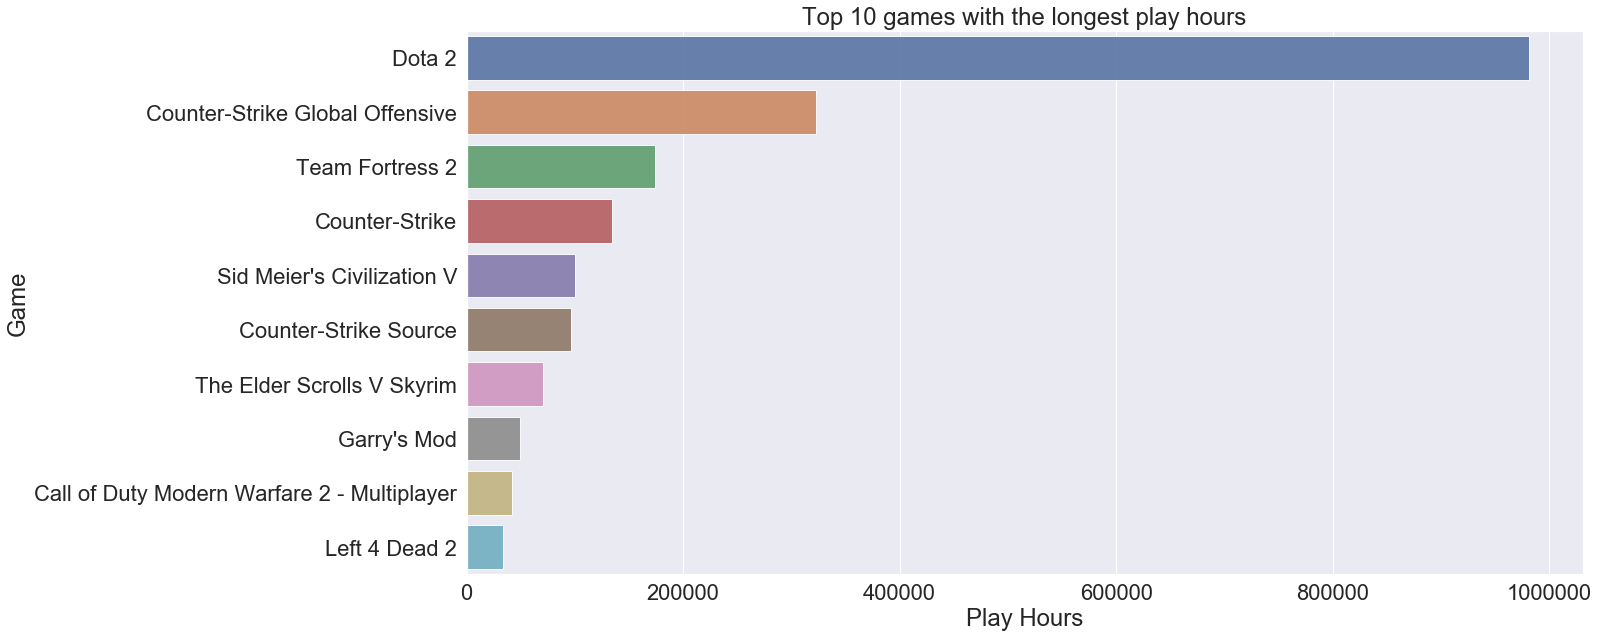

In [43]:
# Plot the top 10 games with the most play hours
plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)
ax = sns.barplot(x='hrs', y='game', alpha=0.9, data=total_hours_game[:10], dodge=False)
ax.set(xlabel='Play Hours', ylabel='Game', title='Top 10 games with the longest play hours')
plt.show()

For some cases there is no relation between the total number of users and the total of hours played, meaning that a high number of users does not represent an equivalent high total of hours played.

In [66]:
# Compute the total number of hours and total number of users per game.
# Only users with 'play' set to 1 are considered.
user_count = user_clean.loc[user_clean['play'] == 1].groupby('game')['id'].agg('count').sort_values(ascending=False)
hours_played = user_clean.loc[user_clean['play'] == 1].groupby('game')['hrs'].agg(np.sum).sort_values(ascending=False)

In [67]:
# Create dataframe of top 20 most played games with total hours and total users per game.
df_top_hours_played = pd.DataFrame({'game_name': hours_played.index,
                                    'hours_played': hours_played.values,
                                    'user_count': user_count.values})[0:20]

In [68]:
# Mask criteria for box plot.
mask_criteria = user_clean['game'].isin(df_top_hours_played['game_name'])
df_box_plot = user_clean.loc[mask_criteria].loc[user_clean['play'] == 1][['hrs', 'game']]

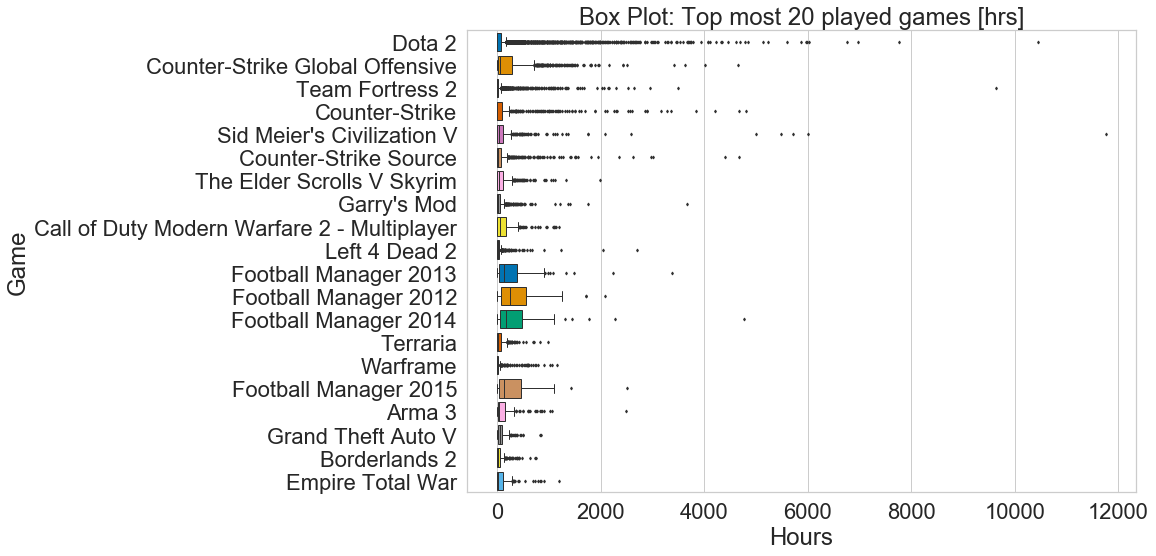

In [78]:
# Create box-plot.
fig_h = 1 + 0.25 * max(1, 30)
fig, ax = plt.subplots(figsize=(12, fig_h))
sns.set_style("whitegrid")
ax = sns.boxplot(x=col_hour, y=col_game, data=df_box_plot,
                order=df_top_hours_played['game_name'].to_list(),
                palette="colorblind",
                saturation=1,
                linewidth=1,
                fliersize=2)
plt.title('Box Plot: Top most 20 played games [hrs]')
plt.xlabel('Hours')
plt.ylabel('Game')
plt.show()

75% of data points for each game is in the range of hundreds of hours, with several games having very large outliers. 

In [79]:
# Remove users with less 2 hours play time, because the Steam allows user to refund the game within 2 hours
user_final = user_clean[user_clean['hrs'] > 2].drop(['purchase', 'play'], axis=1)
user_final.head()

,id,game,hrs
0,5250,Alien Swarm,4.9
1,5250,Cities Skylines,144.0
6,5250,Deus Ex Human Revolution,62.0
17,5250,Portal 2,13.6
21,76767,Age of Empires II HD Edition,13.1


In [ ]:
# Save the final dataframe to file for future use
user_final.to_csv(r'/final_data/user_final.csv', index=None)

## Steam Game Dataset

#### Step 1: Read in the data and take a look at the dataset

In [3]:
df2 = pd.read_csv('data/Steam.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

In [81]:
df2.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [4]:
df2.columns

Index(['appid', 'name', 'release_date', 'english', 'developer', 'publisher',
       'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags',
       'achievements', 'positive_ratings', 'negative_ratings',
       'average_playtime', 'median_playtime', 'owners', 'price'],
      dtype='object')

There are 27075 games with 17 features in the oringinal dataset

#### Step 2: Create the functions to clean the dataset

In [82]:
def get_unique(series):
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

In [84]:
def process_cat_gen_tag(df):
    cat_cols = get_unique(df['categories'])
    
   
    cat_cols = [
        'Local Multi-Player',
        'MMO',
        'Mods',
        'Multi-player',
        'Online Co-op',
        'Online Multi-Player',
        'Single-player'
    ]
    
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['categories'].apply(lambda x: 1 if col in x.split(';') else 0)
        
    gen_cols = get_unique(df['genres'])
    
    
    gen_cols = [
        'Accounting',
        'Action',
        'Adventure',
        'Animation & Modeling',
        'Audio Production',
        'Casual',
        'Design & Illustration',
        'Documentary',
        'Early Access',
        'Education',
        'Free to Play',
        'Game Development',
        'Gore',
        'Indie',
        'Massively Multiplayer',
        'Nudity',
        'Photo Editing',
        'RPG',
        'Racing',
        'Sexual Content',
        'Simulation',
        'Software Training',
        'Sports',
        'Strategy'
        'Tutorial',
        'Utilities',
        'Video Production',
        'Violent',
        'Web Publishing'
    ]
    
    gen_col_names = []
    
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['genres'].apply(lambda x: 1 if col in x.split(';') else 0)
    
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0]
        
    tag_cols = get_unique(df['steamspy_tags'])
    
    df = df.drop(['categories', 'genres', 'steamspy_tags'], axis=1)
    
    return df

In [85]:
def process_revenue(df):
    df['est_revenue'] = df['owners'] * df['price']
    return df

In [86]:
def process_price(df):
    cut_points = [-1, 0, 4, 10, 30, 50, 1000]
    label_names = ['free', 'very cheap', 'cheap', 'moderate', 'expensive', 'very expensive']
    
    df['price_categories'] = pd.cut(df['price'], cut_points, labels=label_names)
    
    return df

In [98]:
df['owners'] = df['owners'].str.split('-').apply(lambda x: (int(x[0]) + int(x[1])) / 2).astype(int)

In [99]:
def clean(df):
    
    df = process_revenue(df)
    df = process_price(df)
    df = process_cat_gen_tag(df)
    
    return df

In [168]:
# Preprocess the data and show the result
game_clean = clean(df2)
nRow, nCol = game_clean.shape
print(f'There are {nRow} rows and {nCol} columns after preprocessing')

There are 26590 rows and 52 columns after preprocessing


#### Step 3: Exploratory Data Analysis

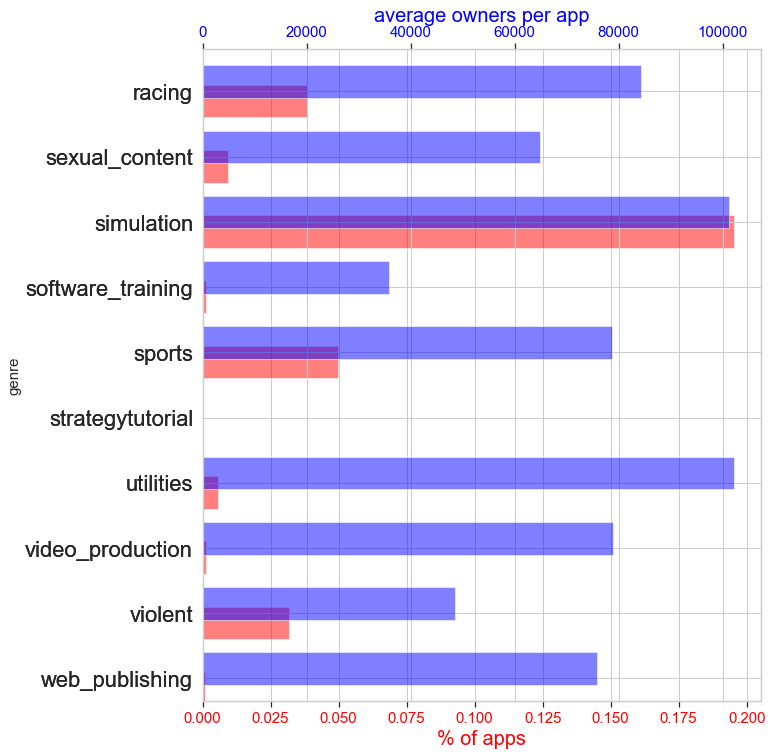

In [128]:
# Shows percentage of apps in each genre
genre_cols = df_clean.columns[-10:]

total_owners_per_genre = df_clean[genre_cols].multiply(df_clean['owners'], axis='index').sum()
average_owners_per_genre = total_owners_per_genre / df_clean[genre_cols].sum()

fig, ax1 = plt.subplots(figsize=(10, 12))
color = 'red'
df_clean[genre_cols].mean().sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.5, position=.8)
ax1.set_ylabel('genre', fontsize=15)
ax1.set_xlabel('% of apps', fontsize=20, color=color)
ax1.tick_params(axis='x', labelsize=15, labelcolor=color)

ax2 = ax1.twiny()
color = 'blue'
average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=.5, position=.2, label='1')
ax2.set_xlabel('average owners per app', fontsize=20, color=color)
ax2.tick_params(axis='x', labelsize=15, labelcolor=color)

plt.show()

## Create the first recommender(user-based) using SVD

The data we have is implicit data. Unlike explicit data, there is no negative feedback, the dataset has only positive feedback, in this particular case is the total hours a user has played in a game, we couldn’t tell the missing value is because the customer did not like the game or just doesn’t know it.
And the numerical value refers to a frequency which might not necessarily reflect the user’s preference. So, I choose to deduce a metric that shows customer’s confidence by using matrix factorization.

The main idea behind matrix factorization is to estimate user matrix from the original sparse matrix by minimizing the cost function that involces 2 important metrics

Preference : Binary metric that indicates if the user has played the game

Confidence: Metric that indicates if the user likes the game

SVD is an algorithm that decomposes a matrix into the best lower rank approximation of the original matrix . Mathematically, it decomposes the original matrix into a two unitary matrices and a diagonal matrix, we take these matrices and keep only the top features, which we think of as the underlying tastes and preferences vectors.

#### Step 1 :Use the user dataset to create pivot table

In [135]:
user_pivot = pd.pivot_table(user_final, values='hrs',index='id',columns='game').fillna(0)

#### Step 2 :Demean the data, normalize by each users mean, and convert it from a dataframe to a numpy array.

In [130]:
user_hours_mean = np.mean(user_pivot, axis = 1)
user_mask = user_pivot - user_hours_mean.values.reshape(-1, 1)

#### Step 3 :Use SVD function from scipy

In [131]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(user_mask, k = 50)

In [132]:
sigma = np.diag(sigma)

The function returns one user ratings matrix, shows how much user like the game, one game matrix shows how relevant each to each game, and one diagonal matrix of singular values (essentially weights)

Then add the user means back to get the actual game ratings prediction

In [133]:
all_user_predicted_hours = np.dot(np.dot(U, sigma), Vt) + user_hours_mean.values.reshape(-1, 1)

#### Step 4 :Create the prediction matrix for each user

In [138]:
preds_df = pd.DataFrame(all_user_predicted_hours, columns = user_pivot.columns, index = user_pivot.index)
preds_df.head()

game,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,16bit Trader,18 Wheels of Steel American Long Haul,1953 NATO vs Warsaw Pact,...,iBomber Defense,iBomber Defense Pacific,ibb & obb,liteCam Game 100 FPS Game Capture,rFactor,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,sZone-Online,theHunter,theHunter Primal
id,,,,,,,,,,,,,,,,,,,,,
5250,0.071210,0.071261,0.071064,0.071409,0.070615,0.070563,0.070720,0.070916,0.070826,0.070942,...,0.071162,0.071000,0.070977,0.070357,0.070817,0.072446,0.072934,0.071376,0.076876,0.072496
76767,0.186387,0.165439,0.165620,0.166378,0.177950,0.165719,0.165336,0.166514,0.160727,0.167200,...,0.166344,0.169148,0.166251,0.144233,0.168299,0.160710,0.160990,0.167991,0.121617,0.171203
86540,-0.008478,-0.007903,-0.002049,-0.005893,-0.001787,-0.000003,-0.002808,-0.007624,-0.002687,-0.007501,...,-0.005831,-0.007367,-0.004157,0.047154,-0.007046,-0.007612,0.021000,-0.005987,-0.035743,-0.015302
229911,0.007043,-0.005780,-0.005308,-0.003549,-0.008947,-0.006982,-0.006833,-0.004522,-0.008981,-0.004358,...,-0.005578,-0.002417,-0.004682,-0.020503,-0.004381,-0.008262,-0.012721,-0.004632,-0.028915,-0.006695
298950,0.215880,0.155123,0.156311,0.148271,0.183320,0.161717,0.176464,0.158815,0.181314,0.159763,...,0.155988,0.147474,0.176198,0.177606,0.147315,0.184700,0.304294,0.170847,0.713382,0.178705


In [19]:
# Save the final dataframe to file for future use
preds_df.to_csv(r'/final_data/preds_df.csv', index=None)

In [140]:
# Select game genre to compare results
user_game = df2[['name', 'genres']]

In [144]:
# Check the prediction metrix with a random user
sorted_user_predictions = preds_df.loc[86540].sort_values(ascending=False)
sorted_user_predictions.head(10)

game
The Elder Scrolls V Skyrim             112.235884
Left 4 Dead 2                           16.284792
Fallout New Vegas                        5.737309
Total War ROME II - Emperor Edition      5.156273
Fallout 4                                4.013135
Star Trek Online                         2.733385
DC Universe Online                       2.440294
Far Cry 3                                2.374429
Left 4 Dead                              2.269500
Saints Row The Third                     2.145683
Name: 86540, dtype: float64

#### Step 5 :Make the function to recommend games to user

In [145]:
def recommend_games(userID, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID
    sorted_user_predictions = preds_df.loc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the game information.
    user_info = user_final[user_final.id == (userID)]
    user_full = (user_info.merge(user_game, how = 'left', left_on = 'game', right_on = 'name').
                     sort_values(['hrs'], ascending=False))

    print ('User {0} has already played {1} games.'.format(userID, user_full.shape[0]))
    print ('Recommending highest {0} predicted play hours user have not played yet.'
           .format(num_recommendations))
    
    # Recommend the highest predicted rating games that the user hasn't seen yet.
    recommendations = (user_game[~user_game['name'].isin(user_full['game'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'name',
               right_on = 'game').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-2])

    return recommendations

In [146]:
# Test the function
recommend_games(76767, 5)

User 76767 has already played 16 games.
Recommending highest 5 predicted play hours user have not played yet.


,name,genres
1223,Crusader Kings II,RPG;Simulation;Strategy
1770,Path of Exile,Action;Adventure;Free to Play;Indie;Massively ...
5223,Elite Dangerous,Action;Adventure;Massively Multiplayer;RPG;Sim...
1465,PAYDAY 2,Action;RPG
2475,Grand Theft Auto V,Action;Adventure


## Create the second recommender(item-based) using KNN

In item-based collaborative filtering, KNN will use a pre-defined distance metric to find clusters of similar items based on users' ratings, and make recommendations using the distance metric in item ratings of top-k nearest neighbors

#### Step 1 :Use the user dataset to create pivot table

In [149]:
game_pivot = pd.pivot_table(user_final, values='hrs',index='game',columns='id').fillna(0)

#### Step 2 :Transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [150]:
from scipy.sparse import csr_matrix
game_sparse = csr_matrix(game_pivot.values)

#### Step 3 :Initialize the NearestNeighbors model and fit sparse matrix to the instance

By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [151]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(game_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [152]:
# Check the KNN recommendations with random games
game_index = np.random.choice(game_pivot.shape[0])
print(game_index)
distances, indices = model_knn.kneighbors(game_pivot.iloc[game_index, :].values.reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print ('Recommendations for {0}:\n'.format(game_index))
    else:
        print ('{0}: {1}, with distance of {2}:'.format(i, game_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

2772
Recommendations for 2772:

1: The Tiny Bang Story, with distance of 0.17946087038837932:
2: SpaceChem, with distance of 0.28207378783580583:
3: Sol Survivor, with distance of 0.45107108183441125:
4: Sanctum, with distance of 0.5717922811485399:
5: Gish, with distance of 0.6832589875208728:


#### Step 4 :Make the function to recommend games to user

In [158]:
def similar_game_recommendations(game, k):
    
    distances, indices = model_knn.kneighbors(game_pivot.loc[game].values.reshape(1, -1), n_neighbors = k + 1)

    for i in range(0, len(distances.flatten())):
        if i == 0:
            print ('Recommendations for {0}:\n'.format(game))
        else:
            print ('{0}: {1}, with distance of {2}:'.format(i, game_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

    return None

In [161]:
# Test the function with game 'Grand Theft Auto V'
similar_game_recommendations('Grand Theft Auto V', 5)

Recommendations for Grand Theft Auto V:

1: RIDE Game, with distance of 0.6513333257556004:
2: Metro Conflict, with distance of 0.6619851429577632:
3: GRID 2, with distance of 0.7621217656364961:
4: Call of Duty 2, with distance of 0.7971407690548458:
5: Red Orchestra 2 Heroes of Stalingrad - Single Player, with distance of 0.8228384179650927:


## Create the third recommender(content-based) using game description

Considering a new user switch from another platform, there is no user information in hand.
content based recommender gives recommendation only based on the similarity between each game

#### Step 1: Read in the game description data

In [162]:
df3 = pd.read_csv('/data/Steam_description.csv')
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27334 entries, 0 to 27333
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   steam_appid           27334 non-null  int64 
 1   detailed_description  27334 non-null  object
 2   about_the_game        27334 non-null  object
 3   short_description     27334 non-null  object
dtypes: int64(1), object(3)
memory usage: 854.3+ KB


#### Step 2: Compare and select one feature to use

In [164]:
df3['is_same'] = (df3['detailed_description'] == df3['about_the_game'])
df3['is_same'].value_counts()

True     24671
False     2663
Name: is_same, dtype: int64

In [165]:
df3['is_equal'] = (df3['about_the_game'] == df3['short_description'])
df3['is_equal'].value_counts()

False    27204
True       130
Name: is_equal, dtype: int64

In [166]:
# All three descriptions are similar in some ways, keep the detail one for future use
des = df3[['steam_appid', 'detailed_description']]
des.shape

(27334, 2)

#### Step 3: Merge description back to the game data frame

In [177]:
game_des = pd.merge(df2, des, left_on='appid', right_on='steam_appid', how='left').drop('steam_appid', axis=1)
game_des.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,sexual_content,simulation,software_training,sports,strategytutorial,utilities,video_production,violent,web_publishing,detailed_description
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,Play the world's number 1 online action game. ...
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,One of the most popular online action games of...
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,0,0,0,0,0,0,0,0,0,Enlist in an intense brand of Axis vs. Allied ...
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,Enjoy fast-paced multiplayer gaming with Death...
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,0,0,0,0,0,0,0,0,0,Return to the Black Mesa Research Facility as ...


In [179]:
# Select out features will be used
description = game_des[['name', 'steamspy_tags', 'detailed_description']]
description.shape

(27075, 3)

In [29]:
# Save the final dataframe to file for future use
description.to_csv(r'/final_data/game_description.csv', index=None)

#### Step 4: Create a tokenizer and transforms words to TFIDF

In [175]:
from nltk.stem import WordNetLemmatizer

import nltk
import string

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmatized_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            lemmatized_word = WordNetLemmatizer().lemmatize(word)

            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/castielyys/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/castielyys/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [180]:
# This cell takes long time to run
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10, tokenizer=my_tokenizer)

index = 0
keys = {}

for game in description.itertuples() :
    key = game[1]
    keys[key] = index
    index += 1
    
    
tfidf.fit(description['detailed_description'])
tfidf_scores = tfidf.transform(description['detailed_description'])
tfidf_scores.shape

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(27075, 17124)

#### Step 5 :Make the function to recommend games to user

In [182]:
#function to look up a game TFIDF by its name.
def get_game_by_name(name, tfidf_scores, keys):
    row_id = keys[name]
    row = tfidf_scores[row_id,:]
    return row

In [183]:
from sklearn.metrics.pairwise import cosine_similarity

def content_recommender(name):
    
    
    similar_games = pd.DataFrame(columns = ["game","similarity"] )
    
    game_1 = get_game_by_name(name, tfidf_scores, keys)
    
    for game in description['name'] :
            
        game_2 = get_game_by_name(name,tfidf_scores,keys)
        similarity = cosine_similarity(game_1,game_2)
        similar_games.loc[len(similar_games)] = [game, similarity[0][0]]
        result_df = similar_games.sort_values(by=['similarity'],ascending=False)[1:6]
        
    return result_df


In [185]:
# Test the function with game 'Grand Theft Auto V'
# This cell takes long time to run
content_recommender('Grand Theft Auto V')

,game,similarity
18033,Clash of Magic VR,1.0
18057,Rocket Armor,1.0
18056,Ultimate Coaster X,1.0
18055,World Warfare,1.0
18054,Bonbon,1.0


In [186]:
a=content_recommender('Grand Theft Auto V')

In [187]:
# Compare description of each recommended game 
testing = pd.merge(description, a, left_on='name', right_on='game', how='right')
testing.drop('game', axis=1)

,name,steamspy_tags,detailed_description,similarity
0,Clash of Magic VR,Early Access;Strategy;VR,Clash of Magic is a VR tower rush game for tru...,1.0
1,Bonbon,Indie;Adventure;Horror,"Bonbon is a short, first-person domestic horro...",1.0
2,World Warfare,Early Access;Strategy;Free to Play,"World Warfare is an intense 3D, Real-time Stra...",1.0
3,Ultimate Coaster X,Early Access;Simulation,Ultimate Coaster X is a free roller coaster si...,1.0
4,Rocket Armor,Early Access;Racing;Simulation,Rocket Armor is the most realistic and excitin...,1.0
